In [37]:
from utils import *
from preprocessing import *
from cnn_model import *
SIZE = 256

In [38]:
'''
# loading data and pre-process

'''
# original image, binary mask, contour(self-defined class)
img_train, mask_train, contour_train = prepareDataset(TRAIN_CONTOUR_PATH, TRAIN_IMG_PATH)
img_test, mask_test, contour_test = prepareDataset(TEST_CONTOUR_PATH, TEST_IMG_PATH)
img_val, mask_val, contour_val = prepareDataset(VAL_CONTOUR_PATH, VAL_IMG_PATH)

#Region of interest, aka bounding box computed from the contour
ROI_train = get_ROI(contour_train)
ROI_test = get_ROI(contour_test)
ROI_val = get_ROI(contour_val)

#Re-organize the data for CNN
img_tv = np.concatenate((img_train, img_val), axis = 0)
roi_tv = np.concatenate((ROI_train, ROI_val), axis = 0)
print(img_tv.shape)
print(roi_tv.shape)

X, Y = reformDataXY(img_tv, roi_tv)
X_test, Y_test = reformDataXY(img_test, ROI_test)

#Get the result from the first step (CNN):

cnn_data = {'X_train': X, 'X_test': X_test, 'Y_train': Y, 'Y_test': Y_test}
y_pred = run_cnn(cnn_data)
cropped = get_cropped(img_test, y_pred, win_size = 100)

print(y_pred.shape)

Number of examples: 260

Processing 260 images and labels ...

Number of examples: 279

Processing 279 images and labels ...

Number of examples: 266

Processing 266 images and labels ...

(526, 256, 256, 1)
(526, 32, 32)
(279, 1, 32, 32)


In [39]:
'''
#probably useless
def get_mask_roi_pred(img, y_pred, roi_size = 32):
    n = img.shape[0]
    mask_roi = np.zeros((n, 256, 256, 1))
    for i in range(y_pred.shape[0]):
        pred = y_pred[i, 0, :,:]
        [x_min, x_max, y_min, y_max] = get_bbox_single(pred)
        mask_roi[i] = cv2.rectangle(mask_roi[i], (x_max,y_max),(x_min,y_min),1,-1)*255   
    return mask_roi

mask_roi =get_mask_roi_pred(img_test,y_pred)
print(mask_roi.shape)
'''

'\n#probably useless\ndef get_mask_roi_pred(img, y_pred, roi_size = 32):\n    n = img.shape[0]\n    mask_roi = np.zeros((n, 256, 256, 1))\n    for i in range(y_pred.shape[0]):\n        pred = y_pred[i, 0, :,:]\n        [x_min, x_max, y_min, y_max] = get_bbox_single(pred)\n        mask_roi[i] = cv2.rectangle(mask_roi[i], (x_max,y_max),(x_min,y_min),1,-1)*255   \n    return mask_roi\n\nmask_roi =get_mask_roi_pred(img_test,y_pred)\nprint(mask_roi.shape)\n'

In [40]:
#get predicted contour mask
def get_mask_pred(img,y_pred):
    n = img.shape[0]
    mask_contour = np.zeros((n, 80, 80, 1))
    for i in range(y_pred.shape[0]):
        pred = y_pred[i, 0, :,:]
        [x_min, x_max, y_min, y_max] = get_bbox_single(pred)
        mask_contour[i] =  img[i][x_min:x_max, y_min:y_max]   
    return mask_contour

mask_contour =get_mask_pred(mask_test,y_pred)
print(mask_contour.shape)

(279, 80, 80, 1)


In [41]:
def open_data_AE(y_pred):
    """
    Open dataset from the output of the CNN and
    unroll it as 64*64 = vector of 4096 elements
    :param y_pred: CNN output
    :return: input AE, output
    """
    input_AE = []
    contour_experts = []
    for j in range(y_pred.shape[0]):
        in_AE = cv2.resize(cropped[j],(64 , 64))
        contour = cv2.resize(mask_contour[j], (64,64), interpolation = cv2.INTERSECT_NONE)
        input_AE.append(in_AE)
        contour_experts.append(contour)
    return np.array(input_AE).reshape((-1, 64*64)), np.array(contour_experts).reshape((-1, 64*64))

In [42]:
X_train, Y_train = open_data_AE(y_pred)
X_train.shape, Y_train.shape

((279, 4096), (279, 4096))

In [43]:
from StackedAeModel import SAE

In [44]:
#apply stacked auto encoder to preprocessed data
h, model = SAE(X_train,Y_train)

Text(0.5,0,u'epochs')

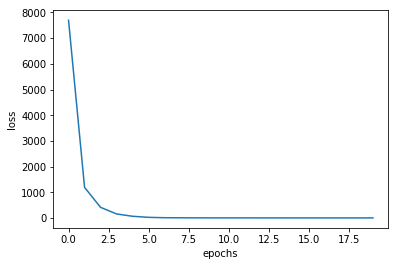

In [45]:
plt.plot(range(len(h)), h)
plt.ylabel('loss')
plt.xlabel('epochs')

In [46]:
def prediction_plot(X, model, idx):
    """
    Compute the Inferred shape binary mask using the trained stacked AE model
    :param X: dataset to predict
    :param model: trained AE model
    :param idx: index of the particular picture to return
    :return: inferred shape binary mask, infered shape on the MR image
    """
    contours = model.predict(X)
    contour = contours[idx].reshape((64,64))
    # thresholding
    binary = cv2.threshold(contour, 0, 1, cv2.INTERSECT_NONE)
    return binary[1], binary[1]*X[idx].reshape(64,64)

In [47]:
#n is number of test images
n = img_test.shape[0]
pred_mask,pred_img=[],[]
for i in range(n):
    bin_mask,img = prediction_plot(X_train,model,i)
    pred_mask.append(bin_mask)
    pred_img.append(img)
pred_mask = np.array(pred_mask)
pred_img = np.array(pred_img)
print (pred_mask.shape)

(279, 64, 64)


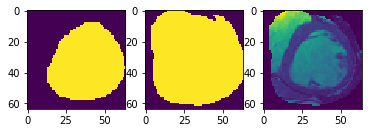

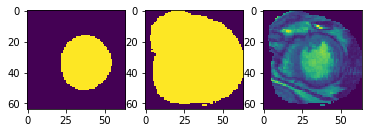

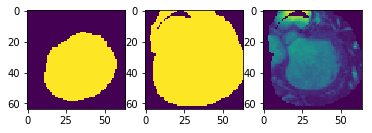

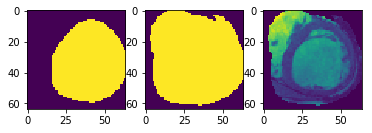

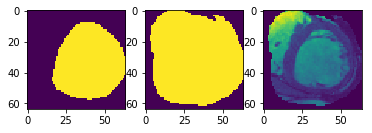

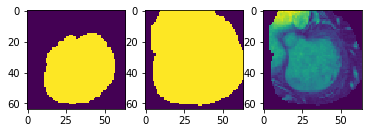

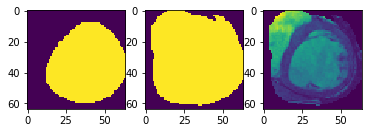

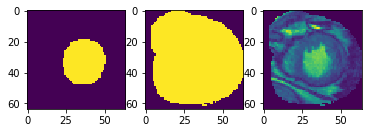

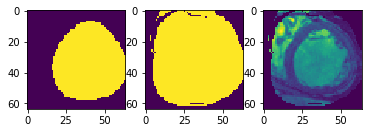

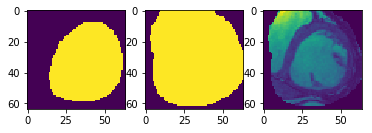

In [48]:
for i in range(10):
    plt.figure()
    plt.subplot(131)
    plt.imshow(Y_train[i].reshape((64,64)))
    plt.subplot(132)
    plt.imshow(pred_mask[i])
    plt.subplot(133)
    plt.imshow(pred_img[i])

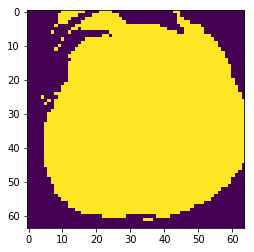

In [49]:
from skimage import measure
pred_mask.shape
img = pred_img[10]

pred_single = pred_mask[10]
contour = measure.find_contours(pred_single, 0.8)
plt.imshow(pred_single)

In [50]:
print(len(contour))


14


In [51]:
#Metrics
def dice_metric(X, Y):
    return np.sum(X[Y==1])*2.0 / (np.sum(X) + np.sum(Y))

def conformity_coefficient(X, Y):
    return (3*dice_metric(X,Y)-2)/dice_metric(X,Y)

In [57]:
dm = np.zeros(n)
cc= np.zeros(n)
for i in range(n):
    Y_true = Y_train[i].reshape((64,64))
    dm[i] = dice_coef(Y_true, pred_mask[i])
    cc[i] = conformity_coefficient(pred_mask[i],Y_true)
#print(dm)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


In [110]:
from skimage import data, img_as_float
from skimage.segmentation import active_contour
from skimage import measure
print(pred_mask.shape)
print(n)
mask = pred_mask[120, :, :]
contours_pred = measure.find_contours(mask, 0.8)
contour_pred = contours_pred[np.argmax([k.shape[0] for k in contours_pred])]
img = X_test[120, :,:,0]
ac_contour = active_contour(img, contour_pred, alpha=0.1, beta=1) 

(279, 64, 64)
279


In [117]:
np.max(contour_pred, axis = 0)

array([61.2, 63. ])

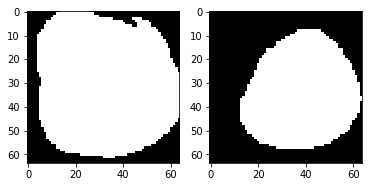

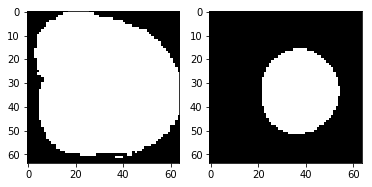

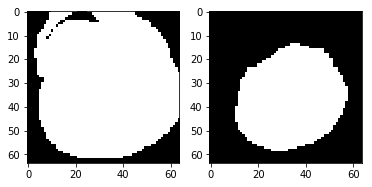

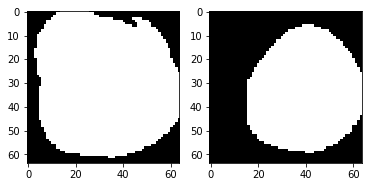

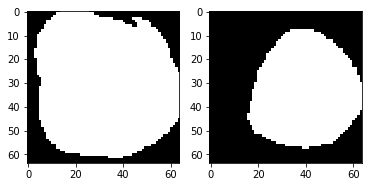

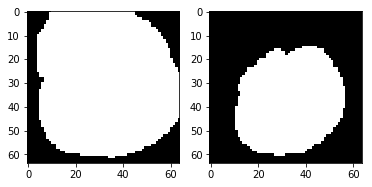

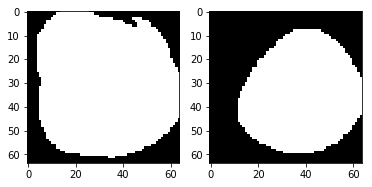

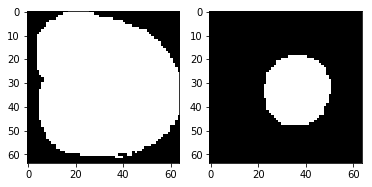

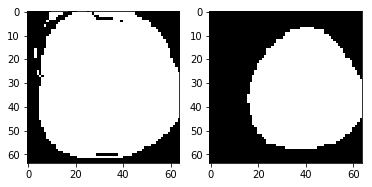

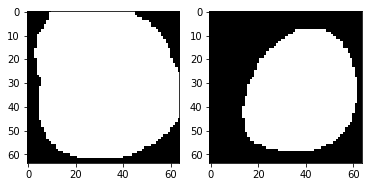

In [111]:
for i in range(10):
    plt.figure()
    fig, ax = plt.subplots(nrows = 1, ncols = 2)
    ax[0].imshow(pred_mask[i, :, :], cmap = 'gray')
    ax[1].imshow(Y_train[i].reshape((64,64)), cmap = 'gray')

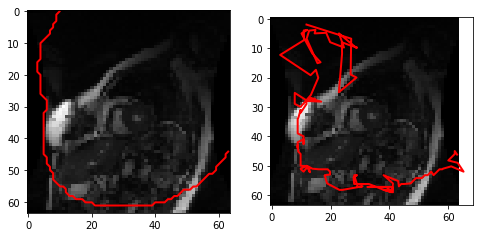

In [113]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,8))
ax[0].imshow(img, cmap = 'gray')
ax[0].plot(contour_pred[:, 1], contour_pred[:, 0], linewidth=2, color='red',label='Prediction')
ax[1].imshow(img, cmap = 'gray')
ax[1].plot(ac_contour[:, 1], ac_contour[:, 0], linewidth=2, color='red',label='Prediction')

In [77]:
print(contour_pred)

[[44.2 63. ]
 [45.  62.2]
 [46.  62.2]
 [46.2 62. ]
 [47.  61.2]
 [47.2 61. ]
 [48.  60.2]
 [48.2 60. ]
 [49.  59.2]
 [50.  59.2]
 [50.2 59. ]
 [51.  58.2]
 [51.2 58. ]
 [51.2 57. ]
 [52.  56.2]
 [52.2 56. ]
 [53.  55.2]
 [53.2 55. ]
 [54.  54.2]
 [54.2 54. ]
 [55.  53.2]
 [55.2 53. ]
 [55.2 52. ]
 [56.  51.2]
 [56.2 51. ]
 [56.2 50. ]
 [56.2 49. ]
 [57.  48.2]
 [57.2 48. ]
 [58.  47.2]
 [58.2 47. ]
 [58.2 46. ]
 [58.2 45. ]
 [59.  44.2]
 [59.2 44. ]
 [59.2 43. ]
 [59.2 42. ]
 [60.  41.2]
 [60.2 41. ]
 [60.2 40. ]
 [60.2 39. ]
 [60.2 38. ]
 [60.2 37. ]
 [61.  36.2]
 [61.2 36. ]
 [61.2 35. ]
 [61.2 34. ]
 [61.2 33. ]
 [61.2 32. ]
 [61.  31.8]
 [60.2 31. ]
 [60.2 30. ]
 [60.2 29. ]
 [60.2 28. ]
 [60.2 27. ]
 [60.2 26. ]
 [60.2 25. ]
 [60.2 24. ]
 [60.2 23. ]
 [60.2 22. ]
 [60.  21.8]
 [59.2 21. ]
 [59.2 20. ]
 [59.2 19. ]
 [59.2 18. ]
 [59.2 17. ]
 [59.2 16. ]
 [59.  15.8]
 [58.2 15. ]
 [58.2 14. ]
 [58.  13.8]
 [57.2 13. ]
 [57.2 12. ]
 [57.  11.8]
 [56.  11.8]
 [55.2 11. ]
 [55.2 10. ]

In [ ]:
'''
for i in range(n):
    mask = pred_mask[i, :, :]
    contours_pred = measure.find_contours(mask, 0.8)
    # the contour might be separated, keep the longest one
    contour_pred = contours_pred[np.argmax([k.shape[0] for k in contours_pred])]
    img = X_test[i, :,:,0]
    ac_contour = active_contour(img, contour_pred, alpha=0.001, beta=0.01) 
'''    